In [1]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install datasets
!pip install huggingface-hub
!pip install joblib
!pip install librosa
!pip install pyctcdecode
!pip install tokenizers

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-flelj0j8
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-flelj0j8
  Resolved https://github.com/huggingface/transformers.git to commit 0a7af19f4dc868bafc82f35eb7e8d13bac87a594
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.45.0.dev0-py3-none-any.whl size=9557589 sha256=5118a78a14c7fa265875e3234cab0d76d7ac00dd50ab293438cd3ccdceb93f9d
  Stored in directory: /tmp/pip-ephem-wheel-cache-qclhr9zc/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
  print('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

Tensorflow version 2.17.0
ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## RAVDESS
Link: https://zenodo.org/records/1188976#.YFZuJ0j7SL8

Filename identifiers

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [4]:
import pandas as pd
import numpy as np

import os
import zipfile

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM, GlobalAveragePooling1D, Layer, TimeDistributed
from keras.callbacks import ModelCheckpoint

Ravdess = 'ravdess/RAVDESS/Audio_Speech_Actors_01-24/'
Crema = 'crema/CREMA/'
Tess = 'tess/TESS/'

In [5]:
from google.colab import drive
drive.mount('/content/drive')
HOME_DIR = '/content/drive/MyDrive/ML3_FP/'

Mounted at /content/drive


In [6]:
def extract_zip(zip_file_path, extraction_path):
  # Create the extraction directory if it doesn't exist
  os.makedirs(extraction_path, exist_ok=True)

  # Check if the file exists
  if not os.path.exists(zip_file_path):
      print(f"Error: File not found at '{zip_file_path}'")
  else:
      # Check if the file is a valid zip file
      if zipfile.is_zipfile(zip_file_path):
          # Create the extraction directory if it doesn't exist
          os.makedirs(extraction_path, exist_ok=True)

          # Unzip the file
          with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
              zip_ref.extractall(extraction_path)

          print(f'Files have been extracted to {extraction_path}')
      else:
          print(f"Error: The file '{zip_file_path}' is not a valid zip file.")

In [7]:
ravdess_extraction_path = 'ravdess'
tess_extraction_path = 'tess'
crema_extraction_path = 'crema'

In [8]:
if not os.path.isdir(ravdess_extraction_path):
  extract_zip(HOME_DIR + 'data/RAVDESS.zip', 'ravdess')
  extract_zip(HOME_DIR + 'data/TESS.zip', 'tess')
  extract_zip(HOME_DIR + 'data/CREMA.zip', 'crema')

Files have been extracted to ravdess
Files have been extracted to tess
Files have been extracted to crema


# Load RAVDESS, TESS, and CREMA-D

In [9]:
def load_ravdess():
  ravdess_directory_list = os.listdir(ravdess_extraction_path + '/RAVDESS/Audio_Speech_Actors_01-24')
  file_emotion = []
  file_path = []
  source = []
  for dir in ravdess_directory_list:
      if os.path.isdir(Ravdess + dir):
          actor = os.listdir(Ravdess + dir)
          for file in actor:
              part = file.split('.')[0]
              part = part.split('-')
              file_emotion.append(int(part[2]))
              file_path.append(Ravdess + dir + '/' + file)
              source.append('RAVDESS')

  # dataframe for emotion of files
  emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

  # dataframe for path of files.
  path_df = pd.DataFrame(file_path, columns=['Path'])

  source_df = pd.DataFrame(source, columns=['Source'])

  Ravdess_df = pd.concat([emotion_df, path_df, source_df], axis=1)

  # changing integers to actual emotions.
  Ravdess_df.Emotions.replace({
      1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'
  }, inplace=True)
  Ravdess_df.head()

  return Ravdess_df

In [10]:
def load_tess():
  tess_directory_list = os.listdir(Tess)

  file_emotion = []
  file_path = []
  source = []

  for file in tess_directory_list:
      if ".wav" in file:
          part = file.split('.')[0]
          part = part.split('_')[2]
          if part=='ps':
              file_emotion.append('surprise')
          else:
              file_emotion.append(part)
          file_path.append(Tess + '/' + file)
          source.append('TESS')

  # dataframe for emotion of files
  emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

  # dataframe for path of files.
  path_df = pd.DataFrame(file_path, columns=['Path'])

  source_df = pd.DataFrame(source, columns=['Source'])

  Tess_df = pd.concat([emotion_df, path_df, source_df], axis=1)
  Tess_df.head()

  return Tess_df

In [11]:
def load_crema():
  crema_directory_list = os.listdir(Crema)

  file_emotion = []
  file_path = []
  source = []

  for file in crema_directory_list:
      # storing file paths
      file_path.append(Crema + file)
      # storing file emotions
      part=file.split('_')
      if part[2] == 'SAD':
          file_emotion.append('sad')
      elif part[2] == 'ANG':
          file_emotion.append('angry')
      elif part[2] == 'DIS':
          file_emotion.append('disgust')
      elif part[2] == 'FEA':
          file_emotion.append('fear')
      elif part[2] == 'HAP':
          file_emotion.append('happy')
      elif part[2] == 'NEU':
          file_emotion.append('neutral')
      else:
          file_emotion.append('Unknown')
      source.append('CREMA-D')

  # dataframe for emotion of files
  emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

  # dataframe for path of files.
  path_df = pd.DataFrame(file_path, columns=['Path'])

  source_df = pd.DataFrame(source, columns=['Source'])

  Crema_df = pd.concat([emotion_df, path_df, source_df], axis=1)
  Crema_df.head()

  return Crema_df

In [12]:
if not os.path.isfile(HOME_DIR + "data_path.csv"):
  Ravdess_df = load_ravdess()
  Tess_df = load_tess()
  Crema_df = load_crema()

  # remove calm and surprise emotion because there are too little occurrences
  Crema_df = Crema_df[Crema_df.Emotions!='calm']
  Ravdess_df = Ravdess_df[Ravdess_df.Emotions!='calm']
  Tess_df = Tess_df[Tess_df.Emotions!='calm']

  # creating Dataframe using all the 4 dataframes we created so far.
  data_path = pd.concat([Ravdess_df, Crema_df, Tess_df], axis = 0)
  data_path.to_csv(HOME_DIR + "data_path.csv",index=False)
else:
  data_path = pd.read_csv(HOME_DIR + "data_path.csv")

## Join all files

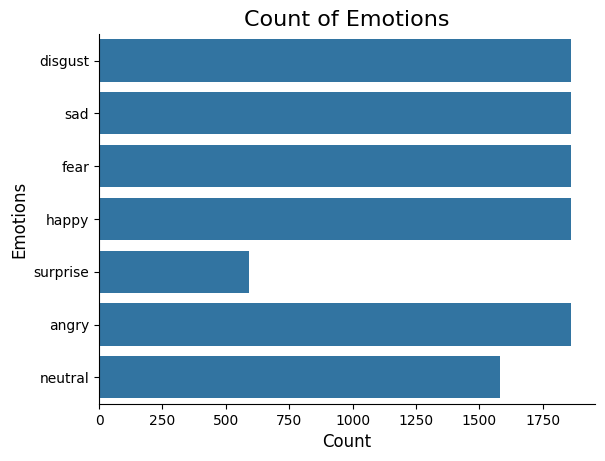

In [13]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Emotions', size=12)
plt.xlabel('Count', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Specify Test Sets

1. TESS and RAVDESS only
2. CREMA-D only
3. TESS, RAVDESS, and CREMA-D

In [28]:
def get_raw_audio_data(df):
  raw_data = []
  for ind, row in df.iterrows():
    temp = {}
    audio = librosa.load(row['Path'], sr=16000)
    temp['audio'] = audio[0]
    temp['label'] = row['label']
    raw_data.append(temp)

  raw_df = pd.DataFrame(raw_data)
  return raw_df

In [31]:
import pandas as pd

mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}

# Test Set 1: RAVDESS, TESS, and SAVEE
test_set_1 = data_path[data_path['Source'].isin(['RAVDESS', 'TESS'])]
test_set_1 = test_set_1.groupby('Emotions').sample(frac=0.1, random_state=42)
train_set_1 = data_path[~data_path.index.isin(test_set_1.index)]

# Test Set 2: CREMA-D only
test_set_2 = data_path[data_path['Source'] == 'CREMA-D']
test_set_2 = test_set_2.groupby('Emotions').sample(frac=0.1, random_state=42)
train_set_2 = data_path[~data_path.index.isin(test_set_2.index)]

# Test Set 3: All datasets
test_set_3 = data_path.groupby('Emotions').sample(frac=0.1, random_state=42)
train_set_3 = data_path[~data_path.index.isin(test_set_3.index)]

# Map the Emotions column to the provided mapping
test_set_1['label'] = test_set_1['Emotions'].map(mapping)
train_set_1['label'] = train_set_1['Emotions'].map(mapping)
test_set_2['label'] = test_set_2['Emotions'].map(mapping)
train_set_2['label'] = train_set_2['Emotions'].map(mapping)
test_set_3['label'] = test_set_3['Emotions'].map(mapping)
train_set_3['label'] = train_set_3['Emotions'].map(mapping)

# Get raw audio data
raw_test_set_1 = get_raw_audio_data(test_set_1)
raw_train_set_1 = get_raw_audio_data(train_set_1)
raw_test_set_2 = get_raw_audio_data(test_set_2)
raw_train_set_2 = get_raw_audio_data(train_set_2)
raw_test_set_3 = get_raw_audio_data(test_set_3)
raw_train_set_3 = get_raw_audio_data(train_set_3)

<ipython-input-31-6f260d55176a>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_1['label'] = train_set_1['Emotions'].map(mapping)
<ipython-input-31-6f260d55176a>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_2['label'] = train_set_2['Emotions'].map(mapping)
<ipython-input-31-6f260d55176a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [32]:
# check label count for each set

print(raw_test_set_1.label.value_counts())
print(raw_test_set_2.label.value_counts())
print(raw_test_set_3.label.value_counts())

print(raw_train_set_1.label.value_counts())
print(raw_train_set_2.label.value_counts())
print(raw_train_set_3.label.value_counts())

label
0    59
1    59
2    59
3    59
5    59
6    59
4    50
Name: count, dtype: int64
label
0    127
1    127
2    127
3    127
5    127
4    109
Name: count, dtype: int64
label
0    186
1    186
2    186
3    186
5    186
4    158
6     59
Name: count, dtype: int64
label
2    1718
3    1705
1    1705
5    1703
0    1699
4    1449
6     497
Name: count, dtype: int64
label
1    1683
3    1681
2    1677
5    1673
0    1671
4    1411
6     520
Name: count, dtype: int64
label
3    1546
2    1543
5    1541
0    1526
1    1524
4    1290
6     462
Name: count, dtype: int64


In [49]:
# Maximum duration of the input audio file we feed to our Wav2Vec 2.0 model.
MAX_DURATION = 3
# Sampling rate is the number of samples of audio recorded every second
SAMPLING_RATE = 16000
BATCH_SIZE = 8  # Batch-size for training and evaluating our model.
NUM_CLASSES = 7  # Number of classes our dataset.
HIDDEN_DIM = 768  # Dimension of our model output (768 in case of Wav2Vec 2.0 - Base).
MAX_SEQ_LENGTH = MAX_DURATION * SAMPLING_RATE  # Maximum length of the input audio file.
# Wav2Vec 2.0 results in an output frequency with a stride of about 20ms.
MAX_FRAMES = 263
MAX_EPOCHS = 2  # Maximum number of training epochs.

MODEL_CHECKPOINT = "r-f/wav2vec-english-speech-emotion-recognition"

In [34]:
import requests

# URL to download the configuration file
config_url = "https://huggingface.co/r-f/wav2vec-english-speech-emotion-recognition/raw/main/config.json"

# Local path to save the configuration file
local_config_path = 'config.json'

if not os.path.isfile(local_config_path):
  # Download the configuration file
  response = requests.get(config_url)

  # Check if the request was successful
  if response.status_code == 200:
      # Save the content to a local file
      with open(local_config_path, 'w') as file:
          file.write(response.text)
      print(f"Configuration file downloaded and saved to {local_config_path}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")

Configuration file downloaded and saved to config.json


In [35]:
# URL to download the preprocessor configuration file
preprocessor_config_url = "https://huggingface.co/r-f/wav2vec-english-speech-emotion-recognition/raw/main/preprocessor_config.json"

# Local path to save the preprocessor configuration file
local_preprocessor_config_path = 'preprocessor_config.json'

if not os.path.isfile(local_preprocessor_config_path):
  # Download the preprocessor configuration file
  response = requests.get(preprocessor_config_url)

  # Check if the request was successful
  if response.status_code == 200:
      # Save the content to a local file
      with open(local_preprocessor_config_path, 'w') as file:
          file.write(response.text)
      print(f"Preprocessor configuration file downloaded and saved to {local_preprocessor_config_path}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")

Preprocessor configuration file downloaded and saved to preprocessor_config.json


In [36]:
# URL to download the model weights (pytorch_model.bin)
weights_url = "https://huggingface.co/r-f/wav2vec-english-speech-emotion-recognition/resolve/main/pytorch_model.bin"

# Local path to save the model weights
local_weights_path = 'model_weights.bin'

if not os.path.isfile(local_weights_path):
  # Download the model weights
  response = requests.get(weights_url)

  # Check if the request was successful
  if response.status_code == 200:
      # Save the content to a local file in binary mode
      with open(local_weights_path, 'wb') as file:
          file.write(response.content)
      print(f"Model weights downloaded and saved to {local_weights_path}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")

Model weights downloaded and saved to model_weights.bin


In [37]:
training_args_url = "https://huggingface.co/r-f/wav2vec-english-speech-emotion-recognition/blob/main/training_args.bin"

# Local path to save the model weights
local_training_args_path = 'training_args.bin'

if not os.path.isfile(training_args_url):
  # Download the model weights
  response = requests.get(training_args_url)

  # Check if the request was successful
  if response.status_code == 200:
      # Save the content to a local file in binary mode
      with open(local_training_args_path, 'wb') as file:
          file.write(response.content)
      print(f"Training args downloaded and saved to {local_training_args_path}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")

Training args downloaded and saved to training_args.bin


In [52]:
from transformers import Wav2Vec2Config, Wav2Vec2Model
import torch.nn as nn
from huggingface_hub import PyTorchModelHubMixin

config = Wav2Vec2Config.from_pretrained(local_config_path)
class Wav2Vec2ForSpeechClassification(nn.Module, PyTorchModelHubMixin):
    def __init__(self, config):
        super(Wav2Vec2ForSpeechClassification, self).__init__()
        self.wav2vec2 = Wav2Vec2Model(config)

        self.classifier = nn.ModuleDict({
            'dense': nn.Linear(config.hidden_size, config.hidden_size),
            'activation': nn.ReLU(),
            'dropout': nn.Dropout(config.final_dropout),
            'out_proj': nn.Linear(config.hidden_size, config.num_labels)
        })

    def forward(self, input_values):
        outputs = self.wav2vec2(input_values)
        hidden_states = outputs.last_hidden_state

        x = self.classifier['dense'](hidden_states[:, 0, :])
        x = self.classifier['activation'](x)
        x = self.classifier['dropout'](x)
        logits = self.classifier['out_proj'](x)

        return logits

# Create the model with the loaded configuration
model = Wav2Vec2ForSpeechClassification(config=config)

print("Model initialized successfully.")

Model initialized successfully.


In [53]:
import torch

local_weights_path = 'model_weights.bin'

state_dict = torch.hub.load_state_dict_from_url(weights_url, map_location=torch.device('cpu'))

# Load the model's state dictionary from the local file
state_dict = torch.load(local_weights_path, map_location=torch.device('cpu'))

# Apply the weights to the model
model.load_state_dict(state_dict, strict=True)

print("Model weights loaded from local file successfully.")

Model weights loaded from local file successfully.


In [54]:
import json
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Processor

# Load the preprocessor configuration from the local file
with open(local_preprocessor_config_path, 'r') as file:
    preprocessor_config = json.load(file)

# Initialize the preprocessor using the loaded configuration
feature_extractor = Wav2Vec2FeatureExtractor(
    do_normalize=preprocessor_config["do_normalize"],
    feature_extractor_type=preprocessor_config["feature_extractor_type"],
    feature_size=preprocessor_config["feature_size"],
    padding_side=preprocessor_config["padding_side"],
    padding_value=preprocessor_config["padding_value"],
    processor_class_from_name=preprocessor_config["processor_class"],
    return_attention_mask=preprocessor_config["return_attention_mask"],
    sampling_rate=preprocessor_config["sampling_rate"]
)

print("Preprocessor initialized successfully.")

Preprocessor initialized successfully.


In [55]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

# Define the id2label mapping
id2label = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}


def predict(model, feature_extractor, data, max_length, id2label):
    # Extract features
    inputs = feature_extractor(data, sampling_rate=16000, max_length=max_length, return_tensors='tf', padding=True, truncation=True)
    torch_inputs = torch.tensor(inputs['input_values'].numpy(), dtype=torch.float32)

    # Forward pass
    outputs = model(input_values=torch_inputs)

    # Extract logits from the output
    logits = outputs

    # Apply softmax to get probabilities
    probabilities = F.softmax(logits, dim=-1)

    # Get the predicted class index
    predicted_class_idx = torch.argmax(probabilities, dim=-1).item()
    predicted_label = predicted_class_idx

    return predicted_label

# Define the evaluation function
def evaluate_model_inference(model, feature_extractor, dataset, max_length, id2label, raw_df, is_print=False):
    correct_predictions = 0
    total_predictions = len(dataset)

    true_labels = []
    predicted_labels = []

    for i in tqdm(range(total_predictions), desc="Evaluating"):
        predicted_label = predict(model, feature_extractor, dataset[i], max_length, id2label)

        # Get actual label from the dataset
        actual_label = raw_df.iloc[i]['label']

        true_labels.append(actual_label)
        predicted_labels.append(predicted_label)

        # Check if prediction is correct
        if predicted_label == actual_label:
            correct_predictions += 1

        # Print prediction and actual label (optional)
        if is_print:
            print(f"Sample {i}: Predicted label: {predicted_label}, Actual label: {actual_label}")

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions
    return accuracy, true_labels, predicted_labels

In [42]:
def pad_audio(df):
  max_length = max(len(audio) for audio in df["audio"])
  padded_audio = [np.pad(audio, (0, max_length - len(audio))) for audio in df["audio"]]
  padded_audio_array = np.array(padded_audio).astype(float)
  return padded_audio_array, max_length

padded_audio_array_test_set_1, max_length_test_set_1 = pad_audio(raw_test_set_1.drop(['label'], axis=1))
padded_audio_array_train_set_1, max_length_train_set_1 = pad_audio(raw_train_set_1.drop(['label'], axis=1))
padded_audio_array_test_set_2, max_length_test_set_2 = pad_audio(raw_test_set_2.drop(['label'], axis=1))
padded_audio_array_train_set_2, max_length_train_set_2 = pad_audio(raw_train_set_2.drop(['label'], axis=1))
padded_audio_array_test_set_3, max_length_test_set_3 = pad_audio(raw_test_set_3.drop(['label'], axis=1))
padded_audio_array_train_set_3, max_length_train_set_3 = pad_audio(raw_train_set_3.drop(['label'], axis=1))

In [43]:
def eval_and_conf_matrix(model, feature_extractor, padded_audio_array, max_length, id2label, raw_df):
  accuracy, true_labels, predicted_labels = evaluate_model_inference(
      model, feature_extractor, padded_audio_array, max_length, id2label, raw_df)
  print(f" Overall Accuracy: {accuracy:.4f}")
  cm = confusion_matrix(true_labels, predicted_labels)
  plt.figure(figsize = (12, 10))
  cm = pd.DataFrame(cm , index = [i for i in mapping] , columns = [i for i in mapping])
  sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
  plt.title('Confusion Matrix', size=20)
  plt.xlabel('Predicted Labels', size=14)
  plt.ylabel('Actual Labels', size=14)
  plt.show()

Evaluating: 100%|██████████| 404/404 [04:16<00:00,  1.58it/s]


 Overall Accuracy: 0.9728


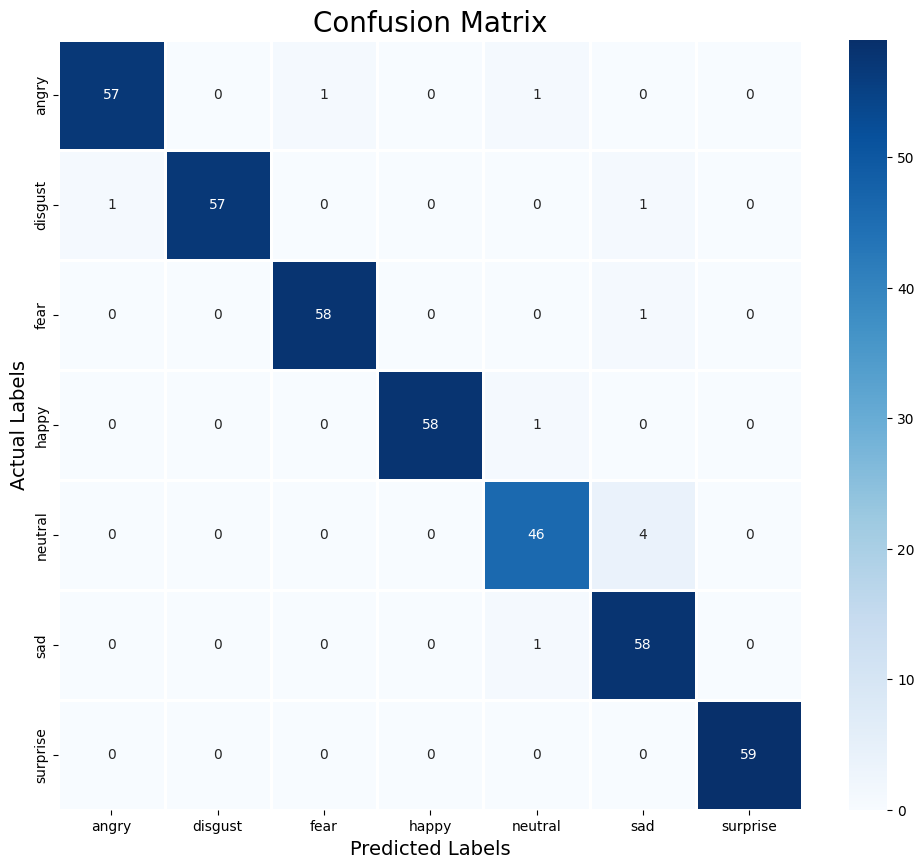

In [44]:
eval_and_conf_matrix(model, feature_extractor, padded_audio_array_test_set_1, max_length_test_set_1, id2label, raw_test_set_1)

Evaluating: 100%|██████████| 744/744 [07:43<00:00,  1.60it/s]


 Overall Accuracy: 0.4288


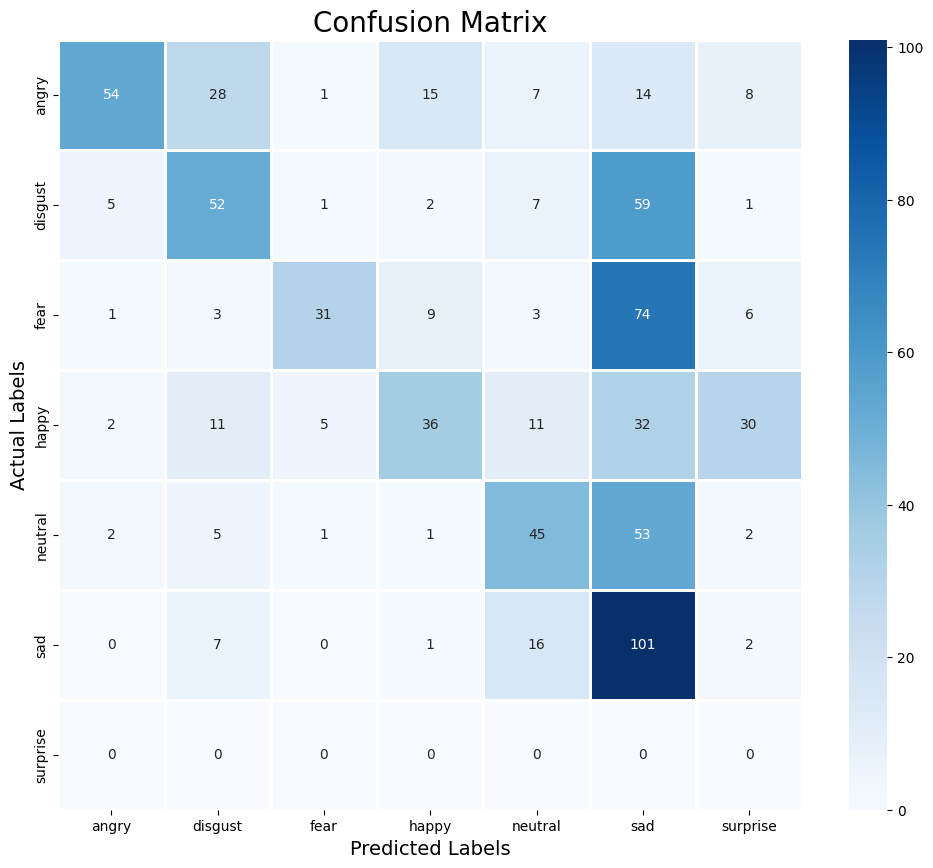

In [45]:
eval_and_conf_matrix(model, feature_extractor, padded_audio_array_test_set_2, max_length_test_set_2, id2label, raw_test_set_2)

Evaluating: 100%|██████████| 1147/1147 [11:26<00:00,  1.67it/s]


 Overall Accuracy: 0.6347


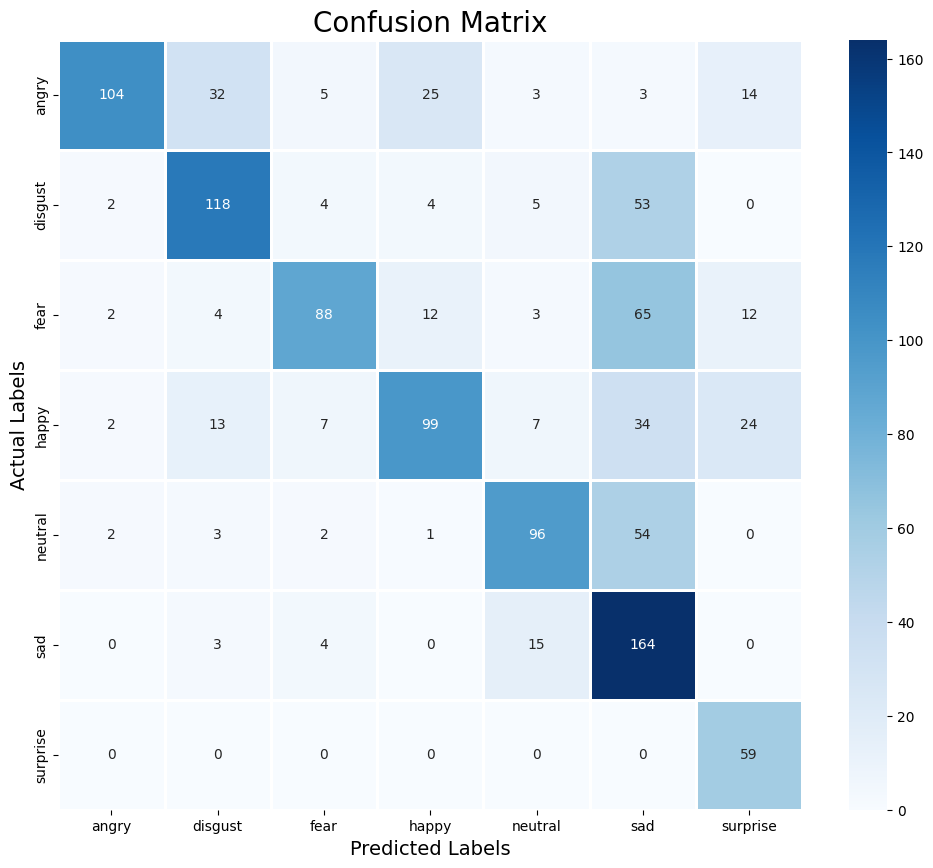

In [46]:
eval_and_conf_matrix(model, feature_extractor, padded_audio_array_test_set_3, max_length_test_set_3, id2label, raw_test_set_3)

<ipython-input-56-790419271629>:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs['input_values'], dtype=torch.float32).to(device)
<ipython-input-56-790419271629>:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(test_inputs['input_values'], dtype=torch.float32).to(device)


Epoch 1


Training: 100%|██████████| 590/590 [05:33<00:00,  1.77it/s]


Training Loss: 0.6806306264536865, Accuracy: 0.7593299406276506


Evaluating: 100%|██████████| 72/72 [00:12<00:00,  5.55it/s]


Evaluation Loss: 0.46380439828822595, Accuracy: 0.8552746294681779
Epoch 2


Training: 100%|██████████| 590/590 [05:33<00:00,  1.77it/s]


Training Loss: 0.4662194456210581, Accuracy: 0.8326972010178118


Evaluating: 100%|██████████| 72/72 [00:12<00:00,  5.54it/s]


Evaluation Loss: 0.4515752530553275, Accuracy: 0.8509154315605929
Epoch 3


Training: 100%|██████████| 590/590 [05:33<00:00,  1.77it/s]


Training Loss: 0.3759494399430893, Accuracy: 0.8672603901611535


Evaluating: 100%|██████████| 72/72 [00:12<00:00,  5.55it/s]


Evaluation Loss: 0.42008117634880665, Accuracy: 0.8587619877942458


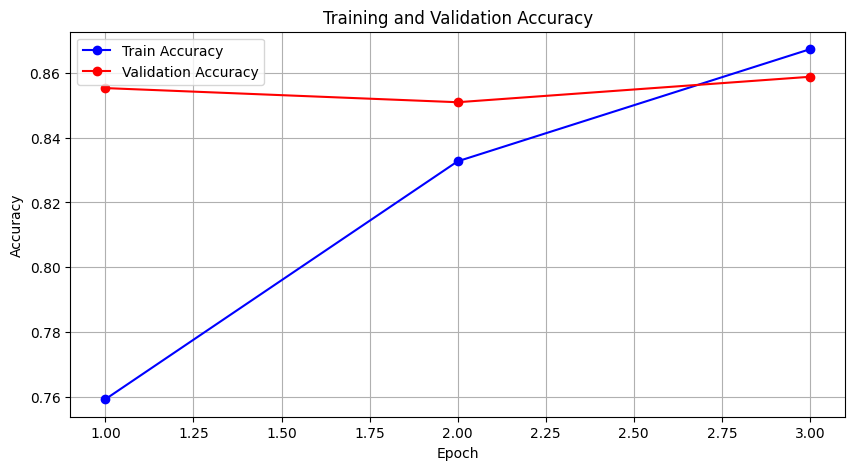

Model saved to /content/drive/MyDrive/ML3_FP//models/model_finetuned.pth


In [56]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.cuda.empty_cache()

# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define CustomDataset
class CustomDataset(Dataset):
    def __init__(self, inputs, labels, label_lengths):
        self.inputs = inputs
        self.labels = labels
        self.label_lengths = label_lengths

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {
            'input_values': self.inputs[idx],
            'labels': self.labels[idx],
            'label_lengths': self.label_lengths[idx]
        }

# Define accuracy computation function
def compute_accuracy(predictions, labels):
    _, predicted = torch.max(predictions, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

# Training function
def train(model, data_loader, optimizer, device, accuracy_history):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(data_loader, desc="Training"):
        # Move data to the same device as the model
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_values=input_values)  # Assumes model returns logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Compute accuracy
        accuracy = compute_accuracy(outputs, labels)
        correct_predictions += (torch.max(outputs, 1)[1] == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = correct_predictions / total_samples
    accuracy_history.append(avg_accuracy)
    print(f"Training Loss: {avg_loss}, Accuracy: {avg_accuracy}")

# Evaluation function
def evaluate(model, data_loader, device, accuracy_history):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            # Move data to the same device as the model
            input_values = batch['input_values'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_values=input_values)  # Assumes model returns logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            # Compute accuracy
            accuracy = compute_accuracy(outputs, labels)
            correct_predictions += (torch.max(outputs, 1)[1] == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = correct_predictions / total_samples
    accuracy_history.append(avg_accuracy)
    print(f"Evaluation Loss: {avg_loss}, Accuracy: {avg_accuracy}")

# Example feature extraction (replace with actual feature extraction code)
train_inputs = feature_extractor(
    padded_audio_array_train_set_3, sampling_rate=16000, max_length=max_length_train_set_3,
    return_tensors='pt', padding=True, truncation=True
)
test_inputs = feature_extractor(
    padded_audio_array_test_set_3, sampling_rate=16000, max_length=max_length_test_set_3,
    return_tensors='pt', padding=True, truncation=True
)

# Convert feature extraction outputs to tensors and move to device
train_inputs = torch.tensor(train_inputs['input_values'], dtype=torch.float32).to(device)
train_labels = torch.tensor(raw_train_set_3.label, dtype=torch.long).to(device)
train_label_lengths = torch.tensor([1 for _ in train_labels], dtype=torch.long).to(device)

test_inputs = torch.tensor(test_inputs['input_values'], dtype=torch.float32).to(device)
test_labels = torch.tensor(raw_test_set_3.label, dtype=torch.long).to(device)
test_label_lengths = torch.tensor([1 for _ in test_labels], dtype=torch.long).to(device)

# Create datasets
train_dataset = CustomDataset(train_inputs, train_labels, train_label_lengths)
eval_dataset = CustomDataset(test_inputs, test_labels, test_label_lengths)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
eval_loader = DataLoader(eval_dataset, batch_size=16, shuffle=False, num_workers=0)

# Initialize accuracy history lists
train_accuracy_history = []
eval_accuracy_history = []

epochs = 3
# Training and evaluation loop
for epoch in range(epochs):  # Number of epochs
    print(f"Epoch {epoch + 1}")
    train(model, train_loader, optimizer, device, train_accuracy_history)
    evaluate(model, eval_loader, device, eval_accuracy_history)

def plot_accuracy(train_accuracy, eval_accuracy):
    epochs = range(1, len(train_accuracy) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracy, 'bo-', label='Train Accuracy')
    plt.plot(epochs, eval_accuracy, 'ro-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot accuracy
plot_accuracy(train_accuracy_history, eval_accuracy_history)

In [60]:
from huggingface_hub import notebook_login

notebook_login()

In [61]:
from huggingface_hub import HfApi

# Save the state dictionary of the model
torch.save(model.state_dict(), f'model_finetuned.pth')
print(f"Model saved to model_finetuned.pth")

api = HfApi()

# Specify the path to your .pth file
file_path = f"model_finetuned.pth"

# Upload the file
api.upload_file(
    path_or_fileobj=file_path,
    path_in_repo="model_finetuned.pth",  # This is the name it will have in the repo
    repo_id="kvilla/wav2vec-english-speech-emotion-recognition-finetuned"
)

Model saved to model_finetuned.pth


model_finetuned.pth:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kvilla/wav2vec-english-speech-emotion-recognition-finetuned/commit/ed22b44dd8cdabfc2650f551a297bf05ff68e46b', commit_message='Upload model_finetuned.pth with huggingface_hub', commit_description='', oid='ed22b44dd8cdabfc2650f551a297bf05ff68e46b', pr_url=None, pr_revision=None, pr_num=None)

In [65]:
# load the newly finetuned model from huggingface repo

from huggingface_hub import hf_hub_download

model_path = hf_hub_download(
    repo_id="kvilla/wav2vec-english-speech-emotion-recognition-finetuned",
    filename="model_finetuned.pth"
)

# load the newly finetuned model! from local
saved_model = torch.load(HOME_DIR + 'models/model_finetuned.pth')

# Create the model with the loaded configuration
model = Wav2Vec2ForSpeechClassification(config=config)

# Load the state dictionary
model.load_state_dict(saved_model)

print("Model initialized successfully.")

model.eval()

model_finetuned.pth:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Model initialized successfully.


Wav2Vec2ForSpeechClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=Tr

Evaluating: 100%|██████████| 404/404 [03:46<00:00,  1.78it/s]


 Overall Accuracy: 0.9950


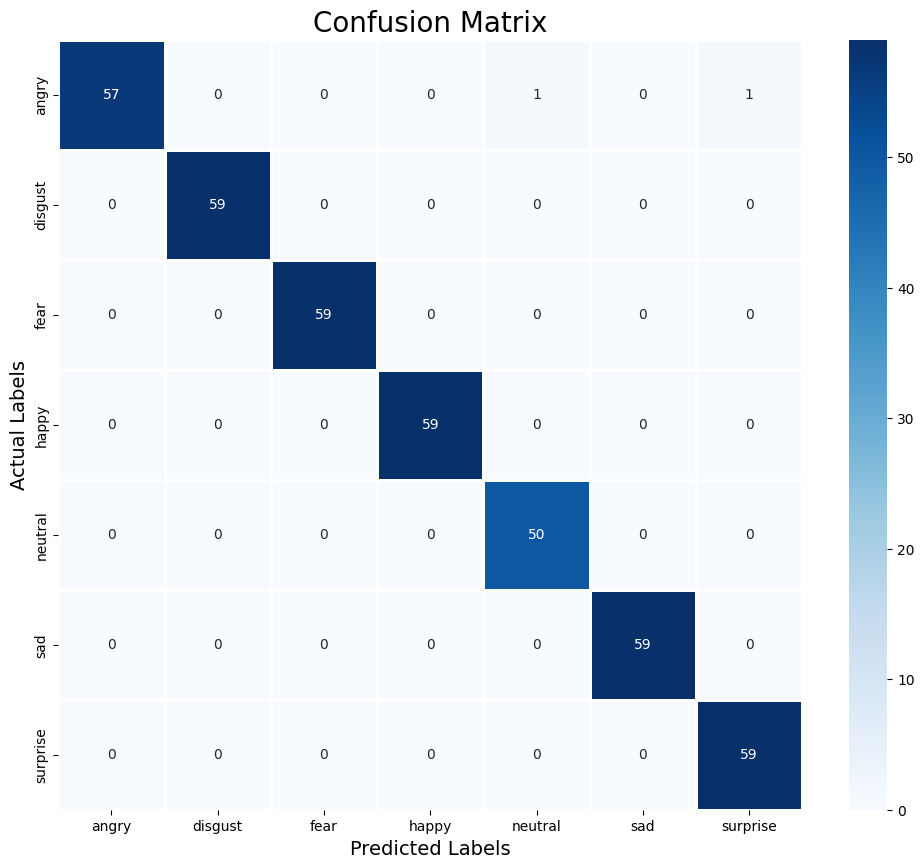

In [66]:
eval_and_conf_matrix(model, feature_extractor, padded_audio_array_test_set_1, max_length_test_set_1, id2label, raw_test_set_1)

In [67]:
eval_and_conf_matrix(model, feature_extractor, padded_audio_array_test_set_2, max_length_test_set_2, id2label, raw_test_set_2)

Evaluating: 100%|██████████| 744/744 [06:47<00:00,  1.82it/s]

 Overall Accuracy: 0.8535


ValueError: Shape of passed values is (6, 6), indices imply (7, 7)

<Figure size 1200x1000 with 0 Axes>

Evaluating: 100%|██████████| 1147/1147 [10:35<00:00,  1.80it/s]


 Overall Accuracy: 0.8588


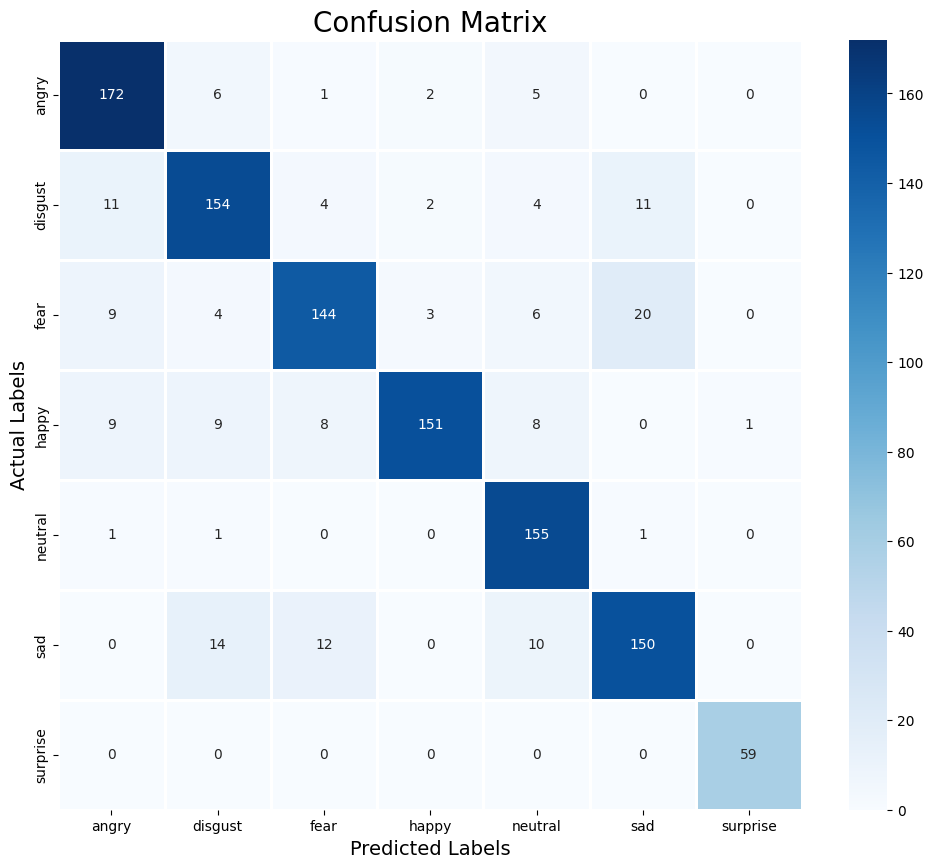

In [68]:
eval_and_conf_matrix(model, feature_extractor, padded_audio_array_test_set_3, max_length_test_set_3, id2label, raw_test_set_3)